# Example - Estimate Excess Surface Density with stacking strategy

we import some clmm modules

In [25]:
import sys
import os
import fnmatch
import pickle
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random


clmm.__version__

'0.3.0'

we import `clmm` module's core.

In [26]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 

we import module for mock data

In [27]:
import mock_data as mock

basic modules

In [28]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we import `DC2Analysis` modules

In [58]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as st
import modeling as model
import statistics as sta
import resampling as rspl
import utils as ut

In [59]:
def load(filename, **kwargs):
    
    """Loads GalaxyCluster object to filename using Pickle"""
    
    with open(filename, 'rb') as fin:
        
        return pickle.load(fin, **kwargs)

for reproductibility :

In [60]:
np.random.seed(11)

we define cosmology into `Cosmology` object

In [61]:
mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

In [62]:
#data = mock.generate_galaxy_catalog(10**4, 0.4, 4, mock_cosmo,  200,'chang13', zsrc_min = 0.4 + 0.1 ,shapenoise = 0.01,ngals=1000)

#mock._compute_photoz_pdfs(data, 0.01)

"""Create GalaxyCluster object"""

#cl = clmm.GalaxyCluster('cluster', 0, 0, 0.4, data)

#print(cl.galcat['z'])

"""Add tangential and cross components"""

#cl = rspl.randomize_redshift(cl)

#print(cl.galcat['z'])

# the critical surface density is recquired then set is_deltasigma = True whatever you estimate reduced shear or deltasigma

#cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = mock_cosmo)

"""Create profile"""

'Create profile'

we define the `Modeling` object `moo` to for the galaxy cluster.

In [63]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Stacking` object `stack` by definning a given range of radial axis, the number of bins for the binned stacked shear profile.

In [64]:
stack = st.Stacking(r_low = 0.5,  r_up = 6, n_bins = 10, cosmo = mock_cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [65]:
deltasigma = True

In [66]:
stack._select_type(is_deltasigma = deltasigma)

In [67]:
nmax = 30

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

We add each galaxy catalogs that correponds to binning to the `stack` object

In [68]:
where_mock = '/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/GalaxyClusterCatalogs/mock_CLMM'

x_list = []

file_name = []

for file in os.listdir(where_mock): 
            
    if (fnmatch.fnmatch(file, 'cluster*') and stack.n_stacked_cluster < nmax):
        
        file_name.append(file)
    
        os.chdir(where_mock)
        
        cl = load(file)

        cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = stack.cosmo)

        bin_edges = pa.make_bins( stack.r_low , stack.r_up , stack.n_bins , method='evenlog10width')

        profile = cl.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=stack.cosmo,include_empty_bins= True,gal_ids_in_bins=True)

        stack._estimate_individual_lensing_signal(cl, profile)

        x_list.append(profile['radius'])

        stack._add_cluster_redshift(cl)

        stack._add_background_galaxies(cl, profile)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [69]:
stack_data = stack

In [70]:
stack_data.MakeStackedProfile() 
stack_data._add_standard_deviation()
stack_data._reshape_data()

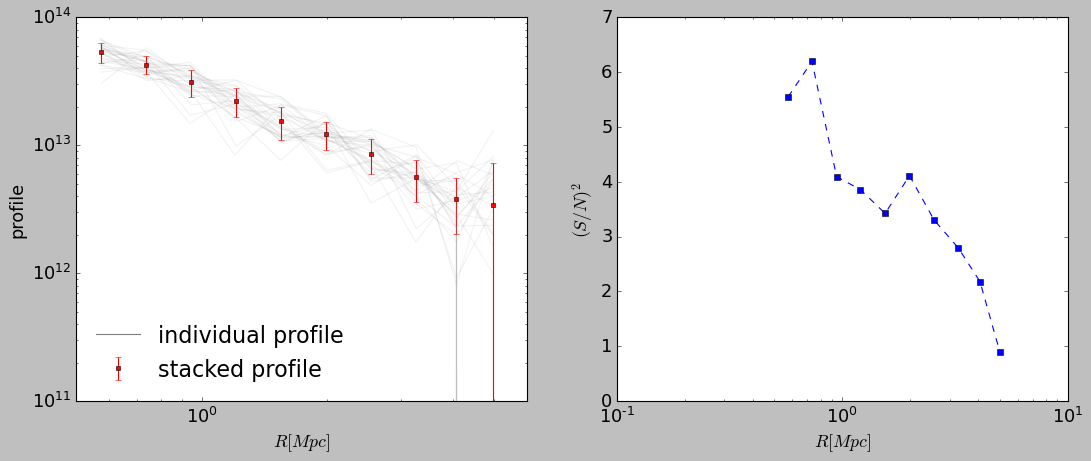

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.style.use('classic')
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

for i in range(stack_data.n_stacked_cluster):
    
    axes[0].plot(x_list[i],stack_data.LS_list[i],c='grey',alpha=0.1)
    
axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].errorbar(stack_data.profile['radius'], stack_data.profile['gt'], stack_data.profile['gt_err'], c = 'r', fmt = 's', ms = 4, label='stacked profile')
axes[0].set_xlabel(r'$R [Mpc]$', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=False, loc = 'best', numpoints = 1)
axes[0].semilogx()
axes[0].semilogy()
#axes[0].set_ylim(10**12,10**14)
axes[0].set_xlim(stack.r_low, stack.r_up)
axes[1].plot(profile['radius'], stack_data.profile['gt']/stack_data.profile['gt_err'], '--s')
axes[1].semilogx()
axes[1].set_xlabel(r'$R [Mpc]$', fontsize=16)
axes[1].set_ylabel(r'$(S/N)^{2}$', fontsize=16)
plt.show()

covariance matrix

In [72]:
n_repetitions = 50

In [73]:
Stat = sta.Statistics(stack_data.n_bins)

In [54]:
where_mock = '/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/GalaxyClusterCatalogs/mock_CLMM'

for repetition in range(n_repetitions):
    
    print('repetition = ' + str(repetition))
    
    stack = st.Stacking(r_low = 0.5,  r_up = 6, n_bins = 10, cosmo = mock_cosmo)
    
    stack._select_type(is_deltasigma = deltasigma)
    
    for file in os.listdir(where_mock): 

        if file in file_name:

            os.chdir(where_mock)

            cl = load(file)
            
            cl = rspl.bootstrap(cl)
            
            cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = stack.cosmo)
        
            bin_edges = pa.make_bins( stack.r_low , stack.r_up , stack.n_bins , method='evenlog10width')

            profile = cl.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=stack.cosmo,include_empty_bins= True,gal_ids_in_bins=True)

            stack._estimate_individual_lensing_signal(cl, profile)

            x_list.append(profile['radius'])

            stack._add_cluster_redshift(cl)

            stack._add_background_galaxies(cl, profile)
            
    stack.MakeStackedProfile() 
    
    Stat._add_realization(stack.profile['gt'])

repetition = 0


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


repetition = 1
repetition = 2
repetition = 3
repetition = 4
repetition = 5
repetition = 6
repetition = 7
repetition = 8
repetition = 9
repetition = 10
repetition = 11
repetition = 12
repetition = 13
repetition = 14
repetition = 15
repetition = 16
repetition = 17
repetition = 18
repetition = 19
repetition = 20
repetition = 21
repetition = 22
repetition = 23
repetition = 24
repetition = 25
repetition = 26
repetition = 27
repetition = 28
repetition = 29
repetition = 30
repetition = 31
repetition = 32
repetition = 33
repetition = 34
repetition = 35
repetition = 36
repetition = 37
repetition = 38
repetition = 39
repetition = 40
repetition = 41
repetition = 42
repetition = 43
repetition = 44
repetition = 45
repetition = 46
repetition = 47
repetition = 48
repetition = 49


We estimate de covariance matrix using `.covariance()` method

In [55]:
Stat.covariance()

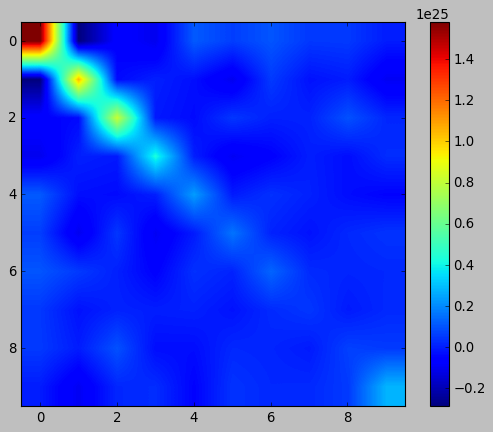

In [56]:
plt.imshow(Stat.covariance)
plt.colorbar()
plt.show()

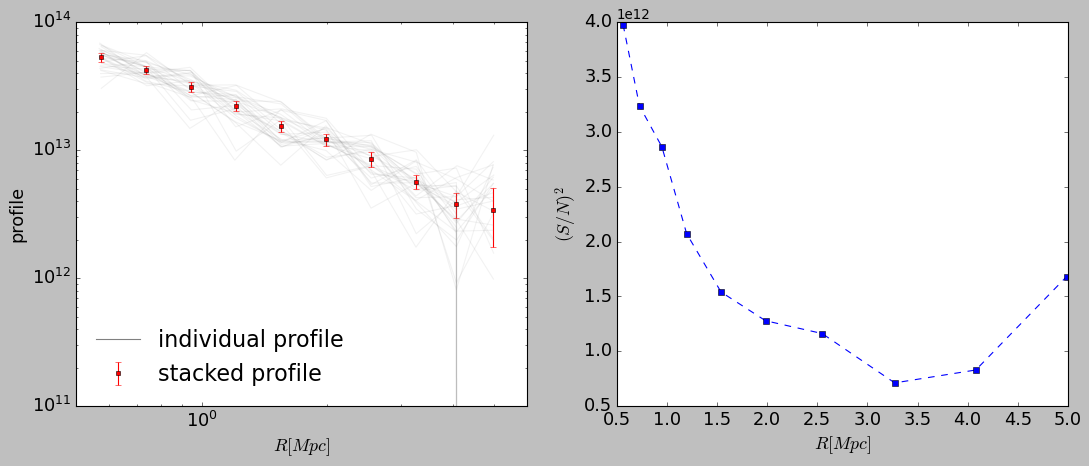

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.style.use('classic')
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

for i in range(stack_data.n_stacked_cluster):
    
    axes[0].plot(x_list[i],stack_data.LS_list[i],c='grey',alpha=0.1)
    
axes[0].plot([],[],c='grey', label='individual profile')    
axes[0].errorbar(stack_data.profile['radius'], stack_data.profile['gt'], np.sqrt(Stat.covariance.diagonal()), c = 'r', fmt = 's', ms = 4, label='stacked profile')
axes[0].set_xlabel(r'$R [Mpc]$', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=20, frameon=False, loc = 'best', numpoints = 1)
axes[0].semilogx()
axes[0].semilogy()
#axes[0].set_ylim(10**12,10**14)
axes[0].set_xlim(stack.r_low, stack.r_up)
axes[1].plot(profile['radius'], np.sqrt(Stat.covariance.diagonal()), '--s')
axes[1].set_xlabel(r'$R [Mpc]$', fontsize=16)
axes[1].set_ylabel(r'$(S/N)^{2}$', fontsize=16)
plt.show()